# Titanic Dataset prediction

## Setup

In [ ]:
! pip install -U kaggle seaborn pandas --quiet

In [ ]:
import kaggle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
from fastai.imports import *

np.set_printoptions(linewidth=130)

In [ ]:
path = Path("/tmp/")
kaggle.api.competition_download_files("titanic", force=True, path=path)
files = ["train.csv", "test.csv", "gender_submission.csv"]
! rm {" ".join(str(path / f) for f in files)}
! unzip {path / "titanic.zip"} -d {path}

Archive:  /tmp/titanic.zip
  inflating: /tmp/gender_submission.csv  
  inflating: /tmp/test.csv           
  inflating: /tmp/train.csv          


In [ ]:
train = pd.read_csv(path / "train.csv")
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C


In [ ]:
test = pd.read_csv(path / "test.csv")
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [ ]:
sample_submission = pd.read_csv(path / "gender_submission.csv")
sample_submission.head(2)

,PassengerId,Survived
0,892,0
1,893,1


## EDA

In [ ]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


Text(0.5, 1.0, 'Gender vs Survived')

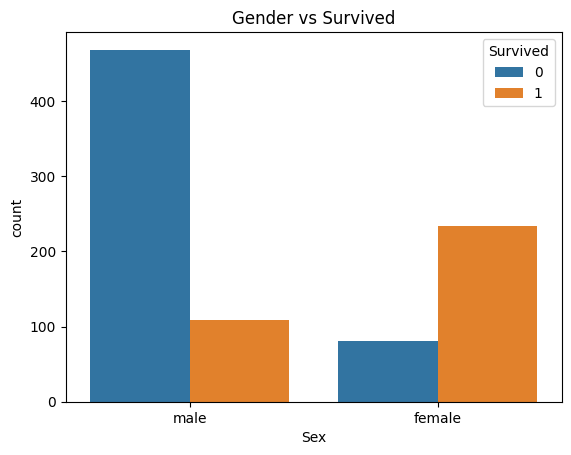

In [ ]:
sns.countplot(train, x="Sex", hue="Survived")
plt.title("Gender vs Survived")

In [ ]:
train['logFare'] = train['Fare'].apply(np.log)

<Axes: xlabel='logFare', ylabel='Count'>

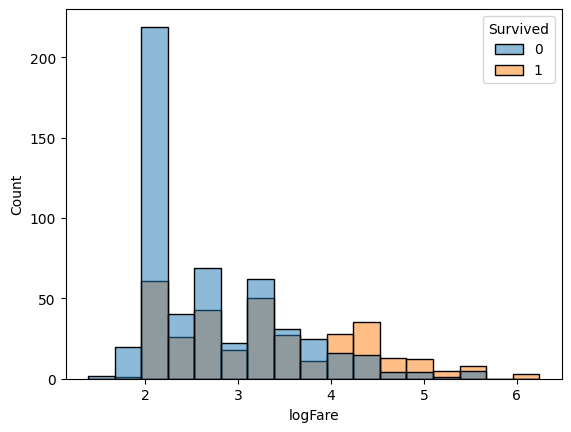

In [ ]:
sns.histplot(train, x="logFare", hue="Survived")

<Axes: xlabel='Age', ylabel='Count'>

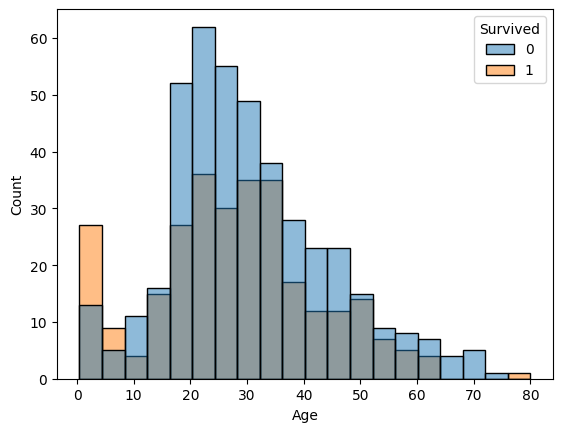

In [ ]:
sns.histplot(train, x="Age", hue="Survived")

<Axes: xlabel='Embarked', ylabel='count'>

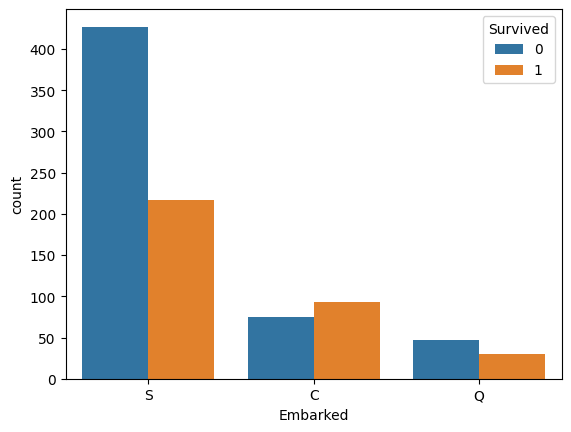

In [ ]:
sns.countplot(train, x="Embarked", hue="Survived")

<Axes: xlabel='SibSp', ylabel='Count'>

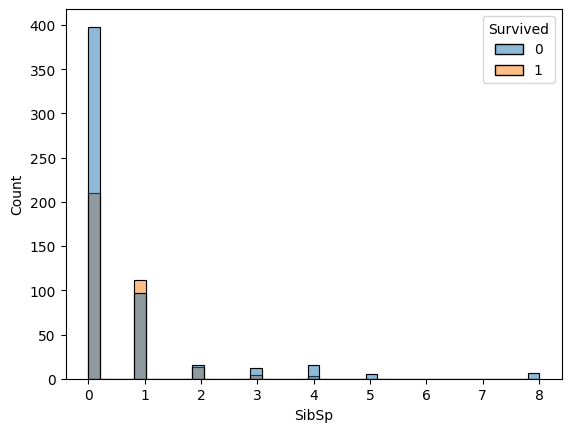

In [ ]:
sns.histplot(train, x="SibSp", hue="Survived")

<Axes: xlabel='Parch', ylabel='Count'>

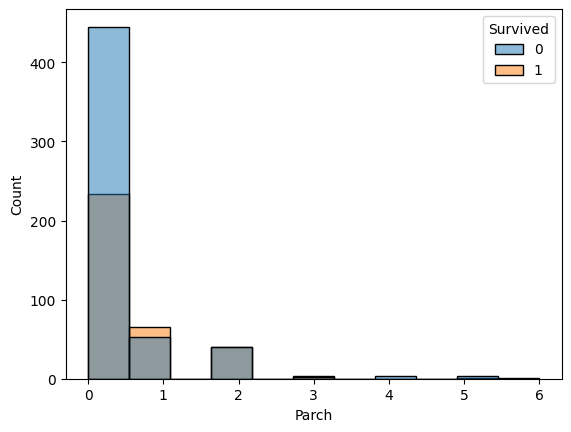

In [ ]:
sns.histplot(train, x="Parch", hue="Survived")

## Evals and metrics

In [ ]:
train, valid = train_test_split(train, test_size=0.2)

In [ ]:
def evaluate(y_targets, y_preds, thresh=0.5):
    # y_targets: classes 0/1
    # y_preds: probs of being 1 (scores)
    y_pred_labels = [1 if s>=thresh else 0 for s in y_preds]
    accuracy = accuracy_score(y_targets, y_pred_labels)
    f1 = f1_score(y_targets, y_pred_labels)
    loss = log_loss(y_targets, y_preds)
    return accuracy, f1, loss
    

## Random Model

In [ ]:
random_model_accuracy, random_model_f1, random_model_loss = evaluate(valid["Survived"].values, np.random.random_sample(len(valid)))
print(f"{random_model_accuracy=} {random_model_f1=} {random_model_loss=}")

random_model_accuracy=0.5363128491620112 random_model_f1=0.4779874213836478 random_model_loss=0.8794932767664191


## Feature Engg

In [ ]:
def feat_engg_pipeline(df, fillna=True):
    x = deepcopy(df)
    x = pd.concat([x, pd.get_dummies(x["Pclass"], prefix="plcass", dummy_na=True, drop_first=True)], axis=1)
    x = pd.concat([x, pd.get_dummies(x["Embarked"], prefix="embarked", dummy_na=True, drop_first=True)], axis=1)
    x = pd.concat([x, pd.get_dummies(x["Sex"], prefix="sex", dummy_na=True, drop_first=True)], axis=1)
    x["logFare"] = x["Fare"].apply(lambda x: max(np.log(x), 0.0001))
    x["SibSp"] = x["SibSp"].apply(lambda x: x if x<2 else 2)
    x["Parch"] = x["Parch"].apply(lambda x: x if x<2 else 2)
    x["age_isnan"] = x["Age"].apply(lambda x: x!=x)
    x["Age"] /= 100
    x = x.fillna(0)
    x = x.drop(["Pclass", "Fare", "Name", "Embarked", "Ticket", "Cabin", "Sex", "PassengerId", "Survived"], axis=1)
    return x

## Logistic Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X = feat_engg_pipeline(train).to_numpy(float)
y = train["Survived"].values

/var/folders/64/2d7m3w55173_15ss4212phx00000gn/T/ipykernel_79547/3317546291.py:6: RuntimeWarning: divide by zero encountered in log
  x["logFare"] = x["Fare"].apply(lambda x: max(np.log(x), 0.0001))


In [ ]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [ ]:
X_val, y_val = feat_engg_pipeline(valid).to_numpy(float), valid["Survived"].values

/var/folders/64/2d7m3w55173_15ss4212phx00000gn/T/ipykernel_79547/3317546291.py:6: RuntimeWarning: divide by zero encountered in log
  x["logFare"] = x["Fare"].apply(lambda x: max(np.log(x), 0.0001))


In [ ]:
y_preds = model.predict_proba(X_val)[:, 1]

In [ ]:
evaluate(y_val, y_preds)

(0.8268156424581006, 0.7832167832167832, 0.4435807485988586)